In [2]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [3]:
# Load dataset
df = pd.read_csv('alzheimers_prediction_dataset.csv')

In [4]:
# Separate features and target
X = df.drop(columns=["Alzheimer’s Diagnosis"])
y = df["Alzheimer’s Diagnosis"].map({'No': 0, 'Yes': 1})  # convert target to 0/1


In [5]:
# Split the data into training and test sets before scaling, encoding to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Dataset V1 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Scaling of numeric features** using `RobustScaler` to reduce the influence of outliers.
2. **Encoding of categorical features** using `OrdinalEncoder`, assigning integer values to each category.

This version will be used to evaluate baseline model performance under these preprocessing conditions.


In [7]:
# Copy original data
X_train_V1 = X_train.copy()
X_test_V1 = X_test.copy()

# Step 1: Scale numeric features using RobustScaler
numeric_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
scaler = RobustScaler()
X_train_V1[numeric_features] = scaler.fit_transform(X_train_V1[numeric_features])
X_test_V1[numeric_features] = scaler.transform(X_test_V1[numeric_features])

# Step 2: Encode categorical features using OrdinalEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_V1[categorical_features] = encoder.fit_transform(X_train_V1[categorical_features])
X_test_V1[categorical_features] = encoder.transform(X_test_V1[categorical_features])

print("Dataset V1 preprocessing complete.")
print("X_train_V1 shape:", X_train_V1.shape)
print("X_test_V1 shape:", X_test_V1.shape)


Dataset V1 preprocessing complete.
X_train_V1 shape: (59426, 24)
X_test_V1 shape: (14857, 24)


### Dataset V2 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Yeo-Johnson transformation** is used on numeric features to address skewness and normalize the distribution.
2. **Categorical features** are encoded using `OrdinalEncoder`.

This dataset version aims to evaluate whether unskewing improves model performance.


In [9]:

# Copy original data
X_train_V2 = X_train.copy()
X_test_V2 = X_test.copy()

# Step 1: Apply Yeo-Johnson transformation to numeric features
numeric_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
yeo = PowerTransformer(method='yeo-johnson')
X_train_V2[numeric_features] = yeo.fit_transform(X_train_V2[numeric_features])
X_test_V2[numeric_features] = yeo.transform(X_test_V2[numeric_features])

# Step 2: Encode categorical features using OrdinalEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_V2[categorical_features] = encoder.fit_transform(X_train_V2[categorical_features])
X_test_V2[categorical_features] = encoder.transform(X_test_V2[categorical_features])

print("Dataset V2 preprocessing complete.")
print("X_train_V2 shape:", X_train_V2.shape)
print("X_test_V2 shape:", X_test_V2.shape)


Dataset V2 preprocessing complete.
X_train_V2 shape: (59426, 24)
X_test_V2 shape: (14857, 24)


### Dataset V3 – Preprocessing Summary

This version of the dataset applies the following preprocessing steps:

1. **Yeo-Johnson transformation** is applied to numeric features to reduce skewness and normalize their distributions.
2. **Categorical features** are encoded using `OneHotEncoder` to allow models to treat each category independently.

This setup is useful for algorithms that benefit from expanded feature representation and non-ordinal categorical handling.


In [11]:
from sklearn.preprocessing import PowerTransformer, OneHotEncoder

# Copy original data
X_train_V3 = X_train.copy()
X_test_V3 = X_test.copy()

# Step 1: Apply Yeo-Johnson transformation to numeric features
numeric_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
yeo = PowerTransformer(method='yeo-johnson')
X_train_V3[numeric_features] = yeo.fit_transform(X_train_V3[numeric_features])
X_test_V3[numeric_features] = yeo.transform(X_test_V3[numeric_features])

# Step 2: Encode categorical features using OneHotEncoder
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform on training set
X_train_encoded = encoder.fit_transform(X_train_V3[categorical_features])
X_test_encoded = encoder.transform(X_test_V3[categorical_features])

# Get encoded column names
encoded_cols = encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays to DataFrames
import pandas as pd
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train_V3.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test_V3.index)

# Drop original categorical columns and join encoded ones
X_train_V3 = X_train_V3.drop(columns=categorical_features).join(X_train_encoded_df)
X_test_V3 = X_test_V3.drop(columns=categorical_features).join(X_test_encoded_df)

print("Dataset V3 preprocessing complete.")
print("X_train_V3 shape:", X_train_V3.shape)
print("X_test_V3 shape:", X_test_V3.shape)


Dataset V3 preprocessing complete.
X_train_V3 shape: (59426, 74)
X_test_V3 shape: (14857, 74)


### Dataset V4 – Preprocessing Summary

This version of the dataset follows the same preprocessing steps as V3, with an additional dimensionality reduction step:

1. **Yeo-Johnson transformation** is applied to numeric features.
2. **Categorical features** are encoded using `OneHotEncoder`.
3. **PCA** is applied to reduce dimensionality while retaining 95% of the variance.

This version is useful when working with high-dimensional data after encoding, especially for models sensitive to feature count.


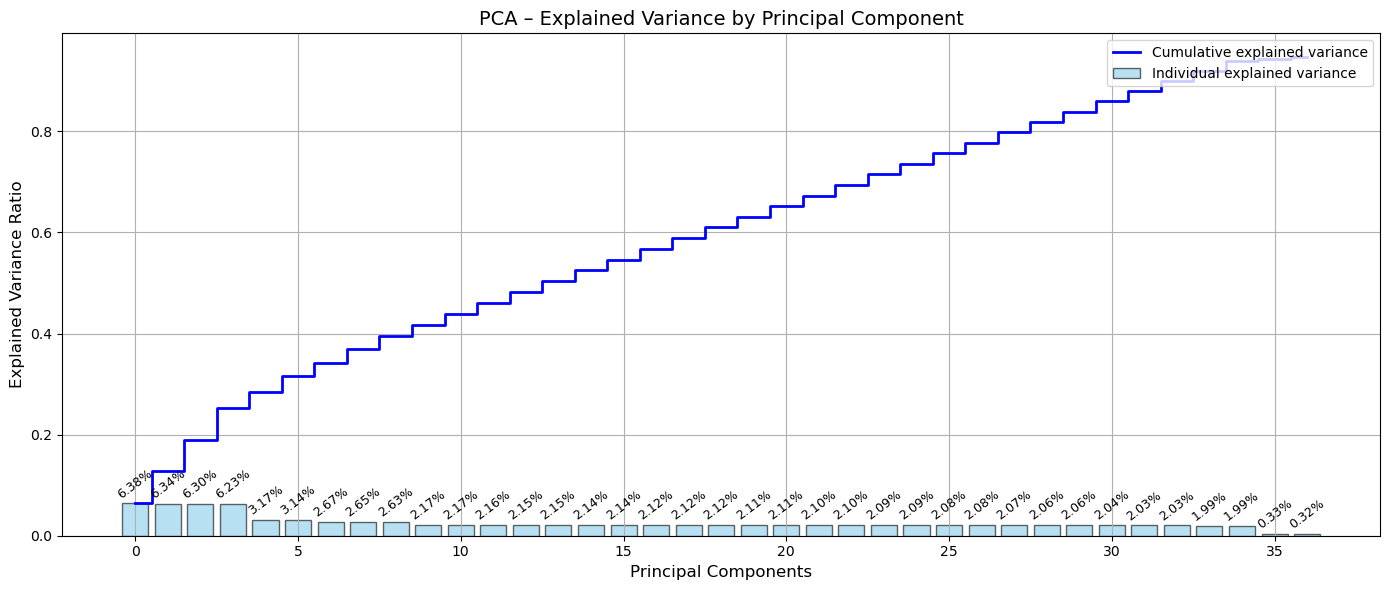

In [13]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Copy Dataset V3 to V4
X_train_V4 = X_train_V3.copy()
X_test_V4 = X_train_V3.copy()  # Note: should this be X_test_V3?

# Step 2: Define a function to visualize variance explained
def print_variance_explained_plot(pca_obj, n_components):
    cum_var_exp = np.cumsum(pca_obj.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(14, 6))

    bars = ax.bar(range(n_components), pca_obj.explained_variance_ratio_,
                  alpha=0.6, align='center',
                  label='Individual explained variance',
                  color='skyblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height*100:.2f}%', ha='center', va='bottom', fontsize=9, rotation=37)

    ax.step(range(n_components), cum_var_exp, where='mid',
            label='Cumulative explained variance', color='blue', linewidth=2)

    ax.set_xlabel('Principal Components', fontsize=12)
    ax.set_ylabel('Explained Variance Ratio', fontsize=12)
    ax.set_title('PCA – Explained Variance by Principal Component', fontsize=14)
    ax.set_xticks(range(0, n_components, 5))
    ax.tick_params(axis='x', labelrotation=0)
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


# Step 3: Fit PCA with 37 components
pca_preview = PCA(n_components=37, random_state=42)
pca_preview.fit(X_train_V4)
print_variance_explained_plot(pca_preview, 37)

### Dataset V4 – PCA Analysis

We applied **PCA** to reduce dimensionality while preserving variance.

- The first components contribute the most.
- Around **37 components** retain ~95% of the total variance.
- This makes the dataset smaller and faster for training, with minimal information loss.

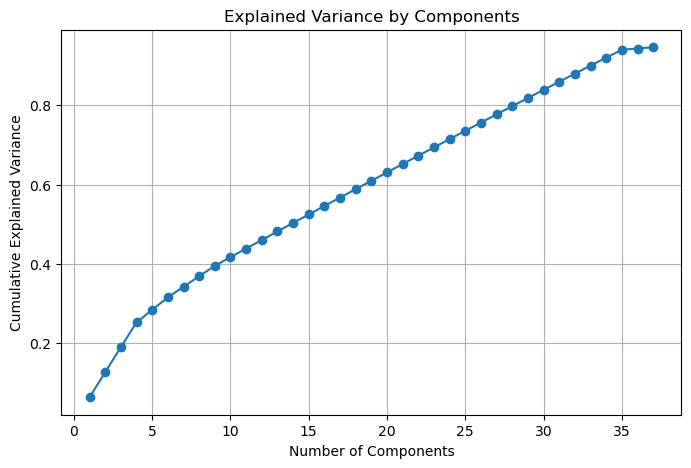

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_preview.explained_variance_ratio_) + 1),
         pca_preview.explained_variance_ratio_.cumsum(),
         marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid()
plt.show()

In [16]:
# Step 4: Apply PCA with 37 components
pca_final = PCA(n_components=37, random_state=42)
X_train_V4 = pca_final.fit_transform(X_train_V4)
X_test_V4 = pca_final.transform(X_test_V4)

print("V4 created using PCA with 37 components.")
print("X_train_V4 shape:", X_train_V4.shape)
print("X_test_V4 shape:", X_test_V4.shape)

V4 created using PCA with 37 components.
X_train_V4 shape: (59426, 37)
X_test_V4 shape: (59426, 37)


### Model Selection – Evaluation of Classifiers on Datasets V1–V4

In this section, we evaluate the performance of multiple classifiers on the four preprocessed versions of our dataset (V1–V4).

#### Classifiers Used:
- Random Forest
- AdaBoost
- XGBoost
- CatBoost
- Support Vector Machine (SVC)
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Decision Tree
- Gaussian Naive Bayes

#### Evaluation Strategy:
- Each classifier is trained on each version of the dataset.
- We use **10-fold cross-validation** with the **weighted F1-score** as the evaluation metric.
- Results are stored and visualized for comparison.

The goal is to identify the top-performing models and dataset versions to carry forward into final testing and/or hyperparameter tuning.


In [18]:
featuresets = {
    'v1': X_train_V1,
    'v2': X_train_V2, 
    'v3': X_train_V3,
    'v4': X_train_V4    
}

# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "SVC": SVC(),
    "KNeighbors": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "GaussianNB": GaussianNB()
}

# Dictionary to store results
results = []

f1_score_weighted = make_scorer(f1_score, average='weighted')

# Loop over each featureset version
for featureset, X_data in featuresets.items():
    # Loop over each classifier
    print(featureset+":", end=' ... ')
    for clf_name, clf in classifiers.items():
        print(clf_name, end=' ... ')
        # Perform 10-fold cross-validation
        scores = cross_val_score(clf, X_data, y_train, cv=10, scoring=f1_score_weighted, n_jobs=-1)
        # Store the average score for this classifier and dataset version
        avg_score = scores.mean()
        results.append({
            'featureset': featureset,
            'classifier': clf_name,
            'score': avg_score
        })
    print()

v1: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v2: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v3: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 
v4: ... RandomForest ... AdaBoost ... XGBoost ... CatBoost ... SVC ... KNeighbors ... LogisticRegression ... DecisionTree ... GaussianNB ... 


In [19]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
results_df

,featureset,classifier,score
0,v1,RandomForest,0.717979
1,v1,AdaBoost,0.728674
2,v1,XGBoost,0.714542
3,v1,CatBoost,0.724185
4,v1,SVC,0.714251
5,v1,KNeighbors,0.616243
6,v1,LogisticRegression,0.707257
7,v1,DecisionTree,0.634689
8,v1,GaussianNB,0.697168
9,v2,RandomForest,0.718385


In [33]:
# Best performing classifiers: SVC, AdaBoostClssifier
results_df.groupby(['classifier'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
classifier,
AdaBoost,0.721551
CatBoost,0.721148
RandomForest,0.714115
SVC,0.712471
XGBoost,0.710930
LogisticRegression,0.709361
GaussianNB,0.677131
KNeighbors,0.639800
DecisionTree,0.633761


In [35]:
# Best performing featureset versions: v1, v2
results_df.groupby(['featureset'])['score'].agg(['mean']).sort_values(by='mean', ascending=False)

,mean
featureset,
v2,0.697910
v1,0.694999
v3,0.693174
v4,0.687370
